## 1. Match web app user with a friend  

This will be done by selecting a survey respondent that matches the replies of the webapp user.

## 2. Compile a profile for the matched friend
This will be done by parsing the responses of the pew survey and combining them into a 
description of the 'friend'.

# 1. Match web app user with a friend

## Loading and parsing responses  
Here, I will   
-load the mcrNums for all respondents  
-split up the respondents based on their matching group  
-randomly pick one friend from the appropriate group  

In [2]:
# So that plots are displayed inline, "plt.show()" not needed.
%matplotlib inline 
#%pylab inline

# Python version
import sys
print('Python: {}'.format(sys.version))
# scipy
import scipy as sp
print('scipy: {}'.format(sp.__version__))
# numpy
import numpy as np
print('numpy: {}'.format(np.__version__))
# matplotlib
import matplotlib as plt
print('matplotlib: {}'.format(plt.__version__))
# pandas
import pandas as pd
print('pandas: {}'.format(pd.__version__))
# scikit-learn
import sklearn as skl
print('sklearn: {}'.format(skl.__version__))

import savReaderWriter as spss
print('savReaderWriter: {}'.format(spss.__version__))
import matplotlib.pylab as pl
import seaborn as sns
import random
import re

#import lightfm

#import docx

# modifying the ast_note_interactivity kernel option to make
# jupyter pretty-print any variable or statement on it’s own line, so you can see the value of multiple statements at once.

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.options.display.max_rows=10   #Sets how many rows are displayed
plt.rc('figure', figsize=(10, 6))

Python: 3.6.0 |Anaconda 4.3.1 (x86_64)| (default, Dec 23 2016, 13:19:00) 
[GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)]
scipy: 0.18.1
numpy: 1.11.3
matplotlib: 2.0.0
pandas: 0.19.2
sklearn: 0.18.1
savReaderWriter: 3.4.2


In [3]:
# Load libraries
from pandas.tools.plotting import scatter_matrix
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

In [4]:
def load_survey_data(savFile):
# Read .sav (SPSS) Data File
# Return df0 pandas dataframe with all data

    #savFile = "./Pew_LGBT/pew2013lgbtpublicdatarelease.sav"

    with spss.SavReader(savFile, returnHeader=True) as reader:
        header = reader.next()
    header = [x.decode('UTF-8') for x in header]
    header=[e.replace('ppagecat','PPAGECAT') for e in header]

    #Upload everything
    data = spss.SavReader(savFile) 
    df0 = pd.DataFrame(data.all())
    df0.columns = header
    data.close()
    #df0.shape
#type(df0)
#print(list(df0.columns[1:40]))
    return df0
df0 = load_survey_data("./Pew_LGBT/pew2013lgbtpublicdatarelease.sav")

csvSavFile="./pewdatasav.csv"
df0.to_csv('csvSavFile.csv', sep=',')
# To get df0 from csv file:
#df0=pd.read_csv('./pewdatasav.csv')

#other ideas: #religious vs nonreligious

In [5]:
# Reduce to questions of interest
# Add "diff" column
# Some needed formatting
# Q24-selfid (0-3)Hetero, gay, lesbian, bi
# Q25 transg 0 yes, 1 no
# LGBT survey defn

# lgbt type Q24
# age sure (Q41)
# age first (Q39)
# how many people aware (Q49)
# how much acceptance now (53) opt-pes (0-3)
# how much acceptance now comp to 10yrs ago (54) opt-pes (-3 to 0)
# how much acceptance in 10 years (55) opt-pes (0-4)
# how important is religion (IMP) (very-not)
# overlapping line plots x:time, color is lgbt type
    
# Just questions of interest
topQsL=['Q24','Q41', 'Q39', 'Q49', 'PPAGECAT','SNS','SEX','Q53','Q54', 'Q55','IMP', 'NEWCASEID']
numQsL=['Q24', 'Q49', 'PPAGECAT','SNS','SEX','Q53','Q54', 'Q55','IMP']
nrows=df0.shape[0]
df1=df0[topQsL][0:nrows]

df1=df1.replace('NaN','-100')
df1=df1.applymap(int)

for question in topQsL: #excluding ages and IDs
    if question in ['Q39','Q41','NEWCASEID']:
        continue
    else:
        df1[question]=df1[question]-1

In [8]:
# shape
print('shape', df1.shape)  

# head
print('head'+'\n', df1.head(20))  

# descriptions
print('describe'+'\n', df1.describe())

shape (1197, 12)
head
     Q24  Q41  Q39  Q49  PPAGECAT  SNS  SEX  Q53  Q54  Q55  IMP  NEWCASEID
0     0   19   17    0         1   -2    1   -2   -2   -2   -2          1
1     1   19    8    0         3    0    0    1    0    0    3          2
2     2   16    7    0         3    0    1    1    1    0    3          3
3     2   18   12    0         4    0    1    1    1    1    3          4
4     1   18   10    0         4    0    0    1    1    0    1          5
..  ...  ...  ...  ...       ...  ...  ...  ...  ...  ...  ...        ...
15    3    9    9    2         3    0    1    2    1    1    3         16
16    3   17   12    2         0    0    1    1    1    1    3         17
17    1   18   11    0         4    0    0    1    0    0    1         18
18    0   20   19    1         1    0    1    1    1    1    1         19
19    1   13   10    1         5    0    0    1    1    1    2         20

[20 rows x 12 columns]
describe
                Q24          Q41          Q39          Q

In [9]:
# How many records are there for each class of flower?
# class distribution
print('groupby(\'lgbt\').size()'+'\n',df1.groupby('Q24').size())

groupby('lgbt').size()
 Q24
-2      7
 0     83
 1    412
 2    262
 3    433
dtype: int64


## Univariate Plots
I start with univariate plots.
For the input variables that are numeric, I can create box and whisker plots.
The edges of the box show the 1st and 3rd quartile (left and right medians of the median), the inside line is the median. The whiskers extend to the min and max values in the data.
This gives us a much clearer idea of the distribution of the input attributes:

In [10]:
len(numQsL)

9

Q24            Axes(0.125,0.657941;0.227941x0.222059)
Q49         Axes(0.398529,0.657941;0.227941x0.222059)
PPAGECAT    Axes(0.672059,0.657941;0.227941x0.222059)
SNS            Axes(0.125,0.391471;0.227941x0.222059)
SEX         Axes(0.398529,0.391471;0.227941x0.222059)
Q53         Axes(0.672059,0.391471;0.227941x0.222059)
Q54               Axes(0.125,0.125;0.227941x0.222059)
Q55            Axes(0.398529,0.125;0.227941x0.222059)
IMP            Axes(0.672059,0.125;0.227941x0.222059)
dtype: object

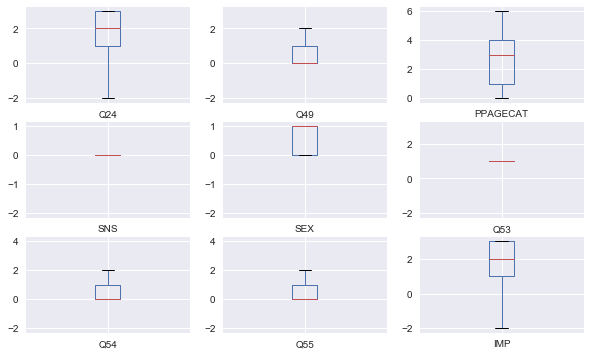

In [11]:
dataset=df1[numQsL]
# box and whisker plots
dataset.plot(kind='box', subplots=True, layout=(3,3), sharex=False)

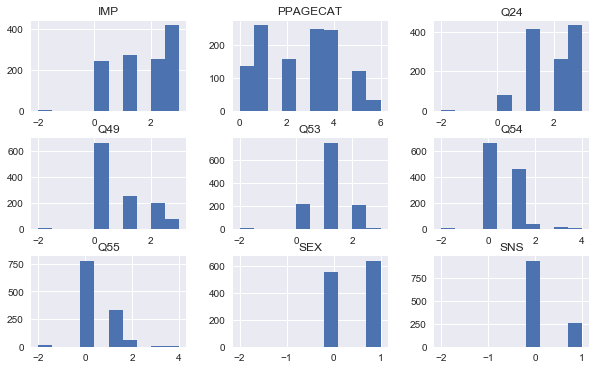

In [12]:
# histograms
# if any of the input variables have a Gaussian distribution. 
# I can use algorithms that can exploit this assumption.
dataset.hist();

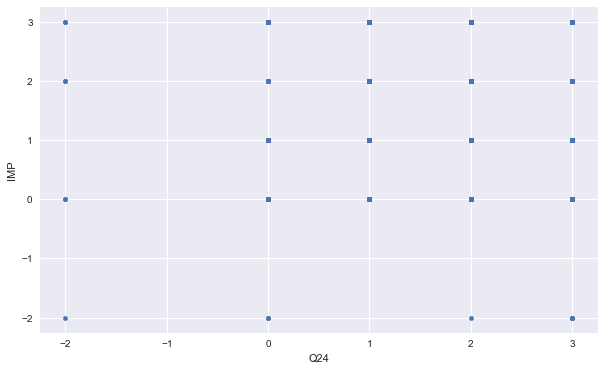

In [13]:
# lgbt type Q24
# age sure (Q41)
# age first (Q39)
# how many people aware (Q49)
# how much acceptance now (53) opt-pes (0-3)
# how much acceptance now comp to 10yrs ago (54) opt-pes (-3 to 0)
# how much acceptance in 10 years (55) opt-pes (0-4)
# how important is religion (IMP) (very-not)
# overlapping line plots x:time, color is lgbt type



dfRel=dataset[['IMP','Q24']]

dfRel.plot.scatter(x='Q24',y='IMP')

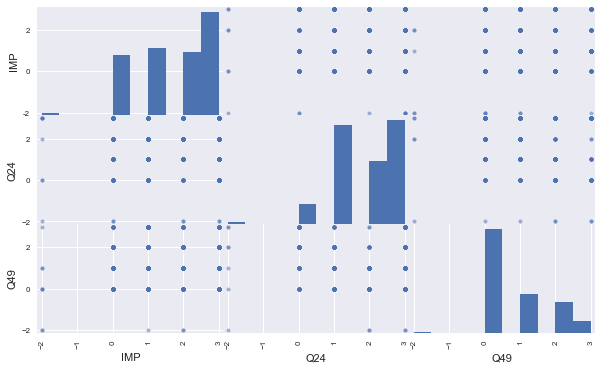

In [14]:
dataset.shape
smdata1=dataset[['IMP','Q24','Q49']]

# scatter plot matrix
scatter_matrix(smdata1);

## Now classify data and compare against given responses.

## Loading and parsing the question and response options from the Pew survey codebook.
In this section, I take the question text from the Pew survey codebook, I create a dataframe with the questions, responses, and the phrases to connect the responses into a blurb about the respondent. 

allQs and topQs will contain question, fields (mcrs), and connector for each question. 
df0 will contain numeric choices of all respondents
mcrNum will be the numbers for each question chosen by friend.

Create a Validation Dataset
I will use statistical methods on the validation set to estimate the accuracy of the models.
I split the loaded dataset into a train set (80%) and a validation set (20%).

In [15]:
# Split-out train and validation (or test) data subsets
array = dataset.values
X = array[:,0:4]
Y = array[:,4] # col 4 is petal width
validation_size = 0.20
seed = 7
X_train, X_validation, Y_train, Y_validation = \
model_selection.train_test_split(X, Y, test_size=validation_size, random_state=seed)

## Test Harness
I'll use a 10-fold cross validation to estimate accuracy.
In 10-fold cross validation, the dataset is split into 10 parts (set n_splits=10, in model.selection), train on 9 and test on 1 and repeat for all combinations of train-test splits.

In [16]:
# Test options and evaluation metric
seed = 7
scoring = 'accuracy'

## Build Models
I'm not sure which algorithms will be good on this problem. The plots show that some of the classes are linearly separable in some dimensions, so I should get decent results.
The 6 different algorithms I'll use are:
Logistic Regression (LR) Linear Discriminant Analysis (LDA) K-Nearest Neighbors (KNN). Classification and Regression Trees (CART). Gaussian Naive Bayes (NB). Support Vector Machines (SVM).
I have some inear (LR and LDA) and nonlinear (KNN, CART, NB and SVM) algorithms.
I set the random number seed before each run to make sure that each algorithm is performed using exactly the same data splits. This ensures that the results will be directly comparable.

In [17]:
dfgay=df1.loc[df1['Q24']==1][['Q54','Q53','Q55']]
dfgay.columns=['t0opti','t1opti','t2opti']
dfgay['t0opti']=[-3-e for e in dfgay['t0opti']]

dfles=df1.loc[df1['Q24']==2][['Q54','Q53','Q55']]
dfles.columns=['t0opti','t1opti','t2opti']
dfles['t0opti']=[-3-e for e in dfles['t0opti']]

dfbi=df1.loc[df1['Q24']==3][['Q54','Q53','Q55']]
dfbi.columns=['t0opti','t1opti','t2opti']
dfbi['t0opti']=[-3-e for e in dfbi['t0opti']]

In [18]:
# Spot Check Algorithms
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))
# evaluate each model
results = []
names = []
for name, model in models:
	kfold = model_selection.KFold(n_splits=10, random_state=seed)
	cv_results = model_selection.cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)

LR: 0.747105 (0.048987)
LDA: 0.750219 (0.053557)
KNN: 0.864211 (0.039293)
CART: 0.869386 (0.015656)
NB: 0.736623 (0.044938)
SVM: 0.862072 (0.016003)


Select the Best Model
KNN has the largest estimated accuracy score.
Since we used 10-fold cross-validation, there are 10 accuracy measures. We can see the spread in the 10 accuracy scores for each algorithm. I can create a plot of the model evaluation results and compare the spread and the mean accuracy of each model.

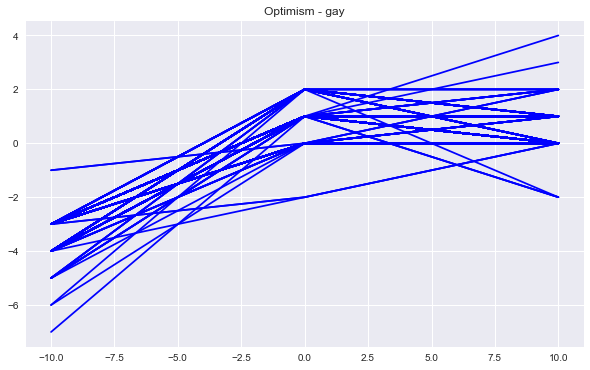

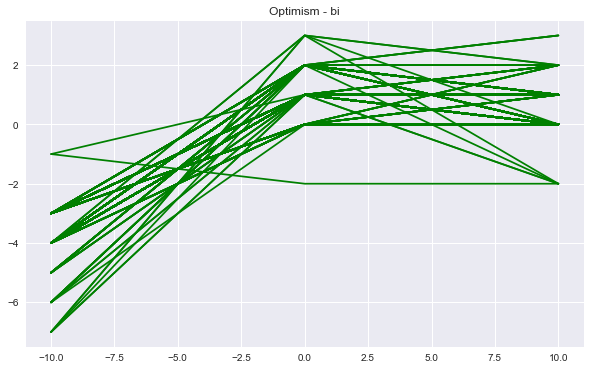

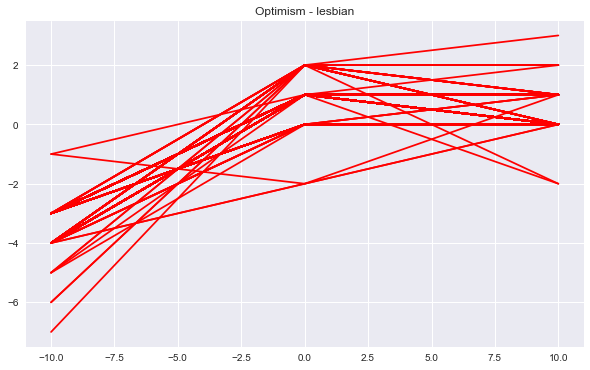

In [32]:
xL=[-10,0,10]
yL={}
for ix in range(0,len(dfgay)):
    inv=dfgay.index.values[ix]
    yL[inv]=list(dfgay.iloc[ix])
    pgay=pl.plot(xL,yL[inv],'b');
pl.title('Optimism - gay');
pl.show()

yL={}
for ix in range(0,len(dfbi)):
    inv=dfbi.index.values[ix]
    yL[inv]=list(dfbi.iloc[ix])
    pbi=pl.plot(xL,yL[inv],'g');
pl.title('Optimism - bi')
#pl.legend(frameon=False, loc='best')
pl.show()

yL2={}
f=pl.figure(1)
for ix in range(0,len(dfles)):
    inv=dfles.index.values[ix]
    yL2[inv]=list(dfles.iloc[ix])
    ples=pl.plot(xL,yL2[inv],'r'); 
pl.title('Optimism - lesbian');
#pl.legend(frameon=False, loc='best')
pl.show()

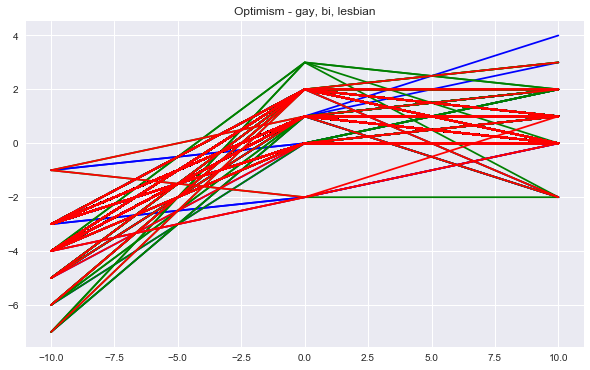

In [33]:
xL=[-10,0,10]
yL={}
for ix in range(0,len(dfgay)):
    inv=dfgay.index.values[ix]
    yL[inv]=list(dfgay.iloc[ix])
    pgay=pl.plot(xL,yL[inv],'b');
#pl.title('Optimism - gay');


yL={}
for ix in range(0,len(dfbi)):
    inv=dfbi.index.values[ix]
    yL[inv]=list(dfbi.iloc[ix])
    pbi=pl.plot(xL,yL[inv],'g');
#pl.title('Optimism - bi')
#pl.legend(frameon=False, loc='best')
#pl.show()

yL2={}
f=pl.figure(1)
for ix in range(0,len(dfles)):
    inv=dfles.index.values[ix]
    yL2[inv]=list(dfles.iloc[ix])
    ples=pl.plot(xL,yL2[inv],'r'); 
pl.title('Optimism - gay, bi, lesbian');
#pl.legend(frameon=False, loc='best')
pl.show()

In [21]:
type(dfgay)
dfgay.shape

dfgayStack=dfgay.stack()
dfgayStack.shape
xL=[1,2,3]
#yL=[]

pandas.core.frame.DataFrame

(412, 3)

(1236,)

In [22]:
df2=df1[:][0:100]
opti1=-3-df2['Q54']
opti2=df2['Q53']
opti3=df2['Q55']
#df2

### Clustering analysis of respondent realization ages and orientation

In [34]:
from pylab import plot,show
from numpy import vstack,array
from numpy.random import rand
from scipy.cluster.vq import kmeans,vq

In [45]:
# data generation
data = vstack((rand(150,2) + array([.5,.5]),rand(150,2)))
#data=dataset[['IMP','Q24']].astype(float)
print(data)


[[ 0.50247212  0.73032638]
 [ 1.46196596  0.61925918]
 [ 0.55659527  1.43915324]
 [ 1.34607409  1.33809119]
 [ 1.36970932  1.34217811]
 [ 1.49611987  0.64376298]
 [ 1.0094627   0.76043392]
 [ 0.62927994  1.00382948]
 [ 1.34629868  1.02831314]
 [ 1.17355456  1.24625733]
 [ 1.30222107  1.42216318]
 [ 1.21853519  1.34503939]
 [ 0.76481885  1.26490159]
 [ 1.32117311  1.33847737]
 [ 1.33032168  0.6702012 ]
 [ 1.33692437  1.19594296]
 [ 1.30047802  0.98444131]
 [ 1.01478021  1.06243094]
 [ 1.14789614  1.20601781]
 [ 0.79199322  0.77063414]
 [ 1.13300435  1.33994591]
 [ 0.66502819  0.75471461]
 [ 0.77088104  0.70805692]
 [ 1.03104096  0.65173538]
 [ 0.74973879  1.03797401]
 [ 0.60614692  0.71366971]
 [ 1.01366849  0.95585127]
 [ 0.73055327  0.8469681 ]
 [ 0.67649624  0.59675265]
 [ 1.41037759  1.1906474 ]
 [ 0.86589766  0.95124492]
 [ 0.77225877  1.4398912 ]
 [ 1.34919949  1.0906087 ]
 [ 1.10685783  0.84205056]
 [ 0.94026858  1.31601861]
 [ 1.18628651  1.32458399]
 [ 0.81088307  0.76563416]
 

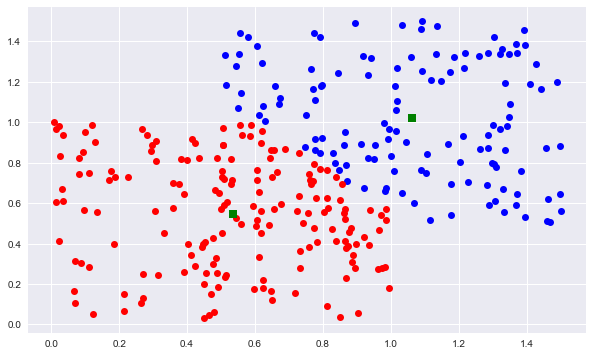

In [46]:
# computing K-Means with K = 2 (2 clusters)
centroids,_ = kmeans(data,2)
# assign each sample to a cluster
idx,_ = vq(data,centroids)

# some plotting using numpy's logical indexing
plot(data[idx==0,0],data[idx==0,1],'ob',
     data[idx==1,0],data[idx==1,1],'or')
plot(centroids[:,0],centroids[:,1],'sg',markersize=8)
show()

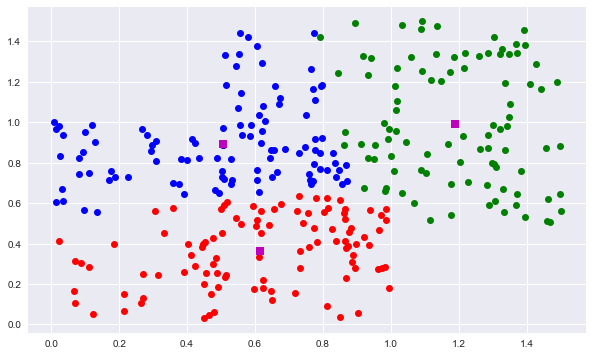

In [47]:
# now with K = 3 (3 clusters)
centroids,_ = kmeans(data,3)
idx,_ = vq(data,centroids)

plot(data[idx==0,0],data[idx==0,1],'ob',
     data[idx==1,0],data[idx==1,1],'or',
     data[idx==2,0],data[idx==2,1],'og') # third cluster points
plot(centroids[:,0],centroids[:,1],'sm',markersize=8)
show()


# Other stuff

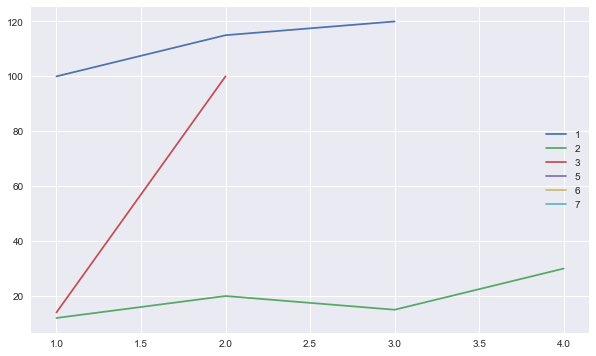

In [23]:
id0        = np.array([1,1,1,2,2,2,2,3,3,5,6,7]) #newcaseid
timestamp = np.array([1,2,3,1,2,3,4,1,2,2,3,4])  #-10,0,10
score     = np.array([100,115,120,12,20,15,30,14,100,20,20,100]) 
pl.figure()
for i in np.unique(id0):     # Loop over all the unique id's
    pw = np.where(id0 == i)  # which elements belong to this id
    pl.plot(timestamp[pw], score[pw], '-x', label=str(i))
pl.legend(frameon=False, loc='best')

In [24]:
optiD= {'years': [-10, 0, 10],
        'user1Opti':[1,2,3],
        'user1Opti':[1,2,3],
        'user1Opti':[1,2,3],
       }

In [25]:
#df1.loc[:,'opti']=[(-10,-3-df1.loc[:,'Q54']),(0,df1.loc[:,'Q53']),(10,df1.loc[:,'Q55'])]
df1.loc[:,'opti']=df1.loc[:,'Q54']
#optim=[1,1,1]
#df1['opti']=optim
#df1['opti_ave']=(opti[3][1]-opti[1][1])/2
len(df1['opti'])
df1.loc[:,'Q53']

1197

0      -2
1       1
2       1
3       1
4       1
       ..
1192    2
1193    0
1194    1
1195    1
1196    1
Name: Q53, dtype: int64

In [26]:
    
x=[-10,0,10] #time
y_range =(-3,8)  # optimism
#for time in [-10,0,10]:
y_opti=[-3-df1['Q54'], df1['Q53'], df1['Q55']]

#print(len(df1[df1['ftype']=='0111']))

In [ ]:
# get subset that are all selfid-bi vs surv-bi
#look at parameters of any that don't agree.





